# Interpretation of medical statistical models should be based on their potential medical benefit
*Where we explore why accuracy and other metrics do no tell the entire story*

# Introduction
DCA is better than just one metric. TODO: breidt dit nog verder uit

# Our case study
Biopsie keuze, wie doen we wel of niet een biopsie aan. Een kern concept is hoeveel 'onnodige' biopsies we willen accepteren. Er zijn verschillende behandelings opties:

- Iedereen een biopsie
- Niemand een biopsie
- Gebruik maken van ervaring of een model om de keuze te maken

Maar wat maakt een goede metric:
- FN en FP zijn niet equally erg
- kan omgaan met onbalans in de data
- Threshold wordt verkent 

In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from helper_functions import *

df_cancer_dx = pd.read_csv('https://raw.githubusercontent.com/ddsjoberg/dca-tutorial/main/data/df_cancer_dx.csv')
df_cancer_train, df_cancer_test = train_test_split(df_cancer_dx, test_size=0.3, stratify=df_cancer_dx['cancer'])

complex_model = sm.GLM.from_formula('cancer ~ age + marker + famhistory', data=df_cancer_dx, family=sm.families.Binomial()).fit()
print(complex_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cancer   No. Observations:                  750
Model:                            GLM   Df Residuals:                      746
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -213.89
Date:                Wed, 28 Feb 2024   Deviance:                       427.79
Time:                        07:44:39   Pearson chi2:                     743.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2130
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -22.0703      2.211     -9.984      0.0

**TODO: Explore the data a bit, show some interesting things**

**TODO: identify intuiiotions. What do you expect to happen givne the data.**

Note that we split the dataset, this is to avoid overfitting. 

To judge which criterium is best for choosing the biopsy, we start with accuracy:

In [8]:
result = calc_metrics(input_prob = {'famhistory': df_cancer_test['famhistory'], 
                                    'complex_model': complex_model.predict(df_cancer_test)},
                      true =       df_cancer_test['cancer'],
                      metrics =    'accuracy')
result

,accuracy_famhistory,accuracy_complex_model,accuracy_everyone,accuracy_noone
0.5,0.782222,0.866667,0.142222,0.857778


which is not really informative. A good option seems to biopsy no one, with , but this is because the prevalence in the dataset of cancer is very low and simply biopsying no one yields a good accuracy. In addition, false negatives and false positives are equally bad. This is obviously not the case: giving someone an uneccesarry biopsy carries some risk, but not catching this kind of cancer means almost certain death. 

In conclusion: accuracy is not a good metric in this situation. 

# Expanding to AUC
[Maybe interesting paper?](https://erj.ersjournals.com/content/58/5/2101186)

In [3]:
result = calc_metrics(input_prob = {'famhistory': df_cancer_test['famhistory'],
                                    'complex_model': complex_model.predict(df_cancer_test)},
                      true =       df_cancer_test['cancer'],
                      metrics =    ['accuracy', 'auc'])
result.T


,0.5
accuracy_famhistory,0.782222
auc_famhistory,0.547199
accuracy_complex_model,0.866667
auc_complex_model,0.839702
accuracy_everyone,0.142222
auc_everyone,0.500000
accuracy_noone,0.857778
auc_noone,0.500000


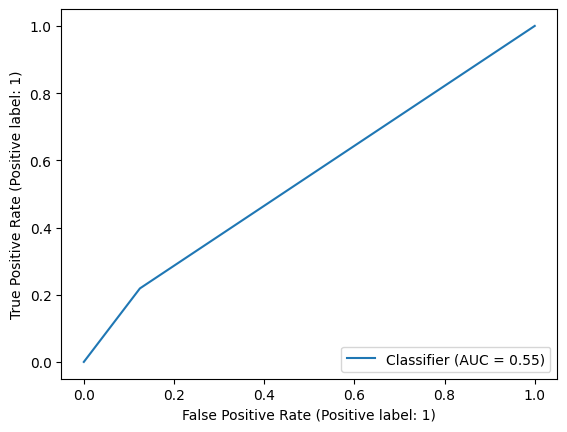

In [4]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_true = df_cancer_test['cancer'], y_pred = df_cancer_test['famhistory'])

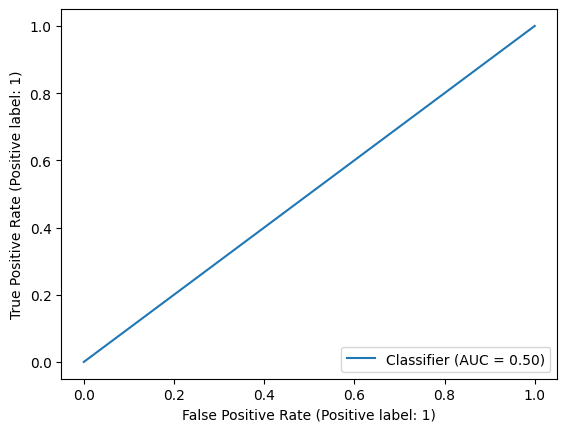

In [7]:
RocCurveDisplay.from_predictions(y_true = df_cancer_test['cancer'], y_pred = np.zeros(len(df_cancer_test['cancer'])) >= 0.5)

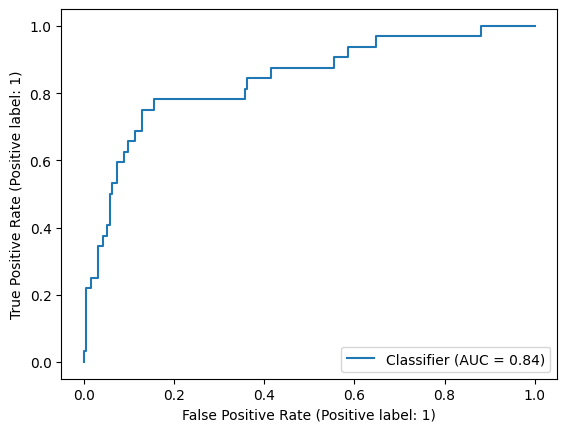

In [6]:
RocCurveDisplay.from_predictions(y_true = df_cancer_test['cancer'], y_pred = complex_model.predict(df_cancer_test))

No way to make FN more impactful than FP. 